# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
from time import time
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
import logging
import matplotlib.pyplot as plt
import six
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [6]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [7]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/ML/Mini Project/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [8]:
## parsing data here
images, labels = parse_data(df)


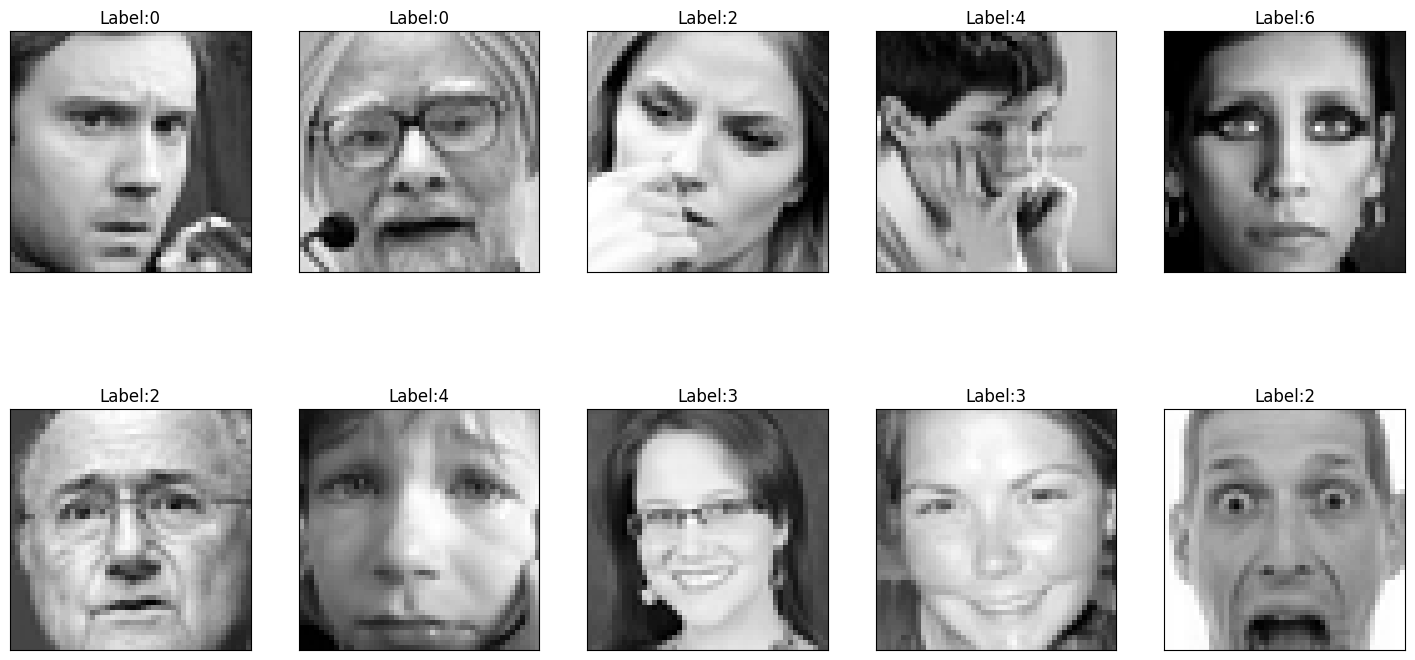

In [9]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [10]:
from sklearn.decomposition import PCA

reshaped_images = images.reshape(images.shape[0], -1)
pca=PCA(n_components=2)
pca.fit(reshaped_images)
images_pca=pca.transform(reshaped_images)

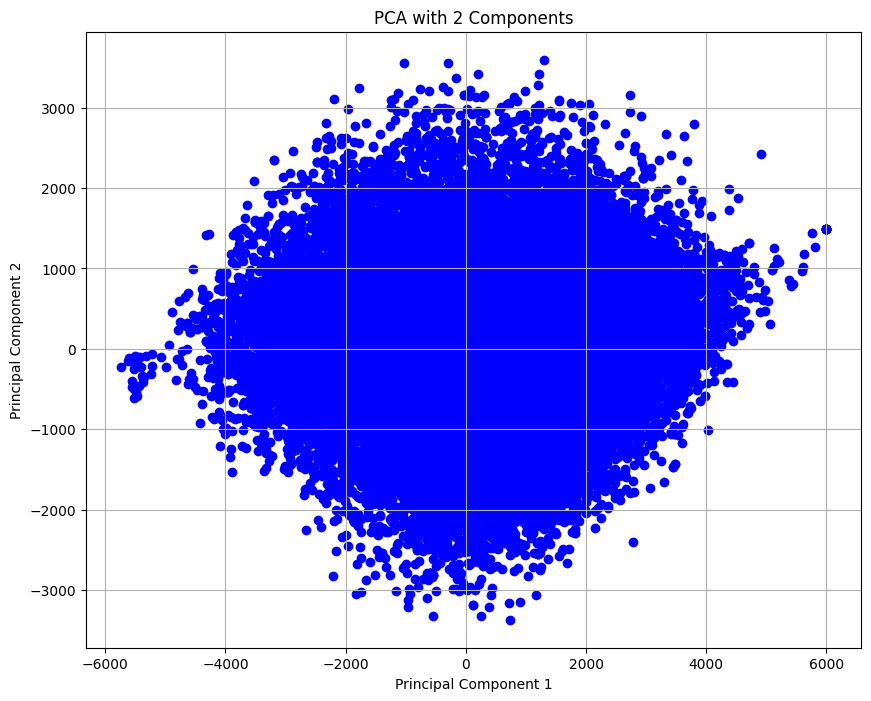

In [11]:
images_pca.shape
plt.figure(figsize=(10, 8))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c="blue", marker='o')
plt.title("PCA with 2 Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [12]:
# PCA with 30 components
pca=PCA(n_components=30)
pca.fit(reshaped_images)
pca

PCA(n_components=30)

In [13]:
k = 30
variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(variance_ratio)

In [14]:
variance_ratio

array([0.2892651 , 0.0980239 , 0.09425532, 0.05505347, 0.03059787,
       0.02573777, 0.02148988, 0.01973357, 0.01780996, 0.01510637,
       0.01167386, 0.0106712 , 0.01024019, 0.00995803, 0.009295  ,
       0.00818261, 0.00786427, 0.00661904, 0.00547504, 0.00534996,
       0.00533005, 0.00502416, 0.00488932, 0.00469357, 0.00444523,
       0.00414392, 0.00411873, 0.00381009, 0.00343784, 0.00337295])

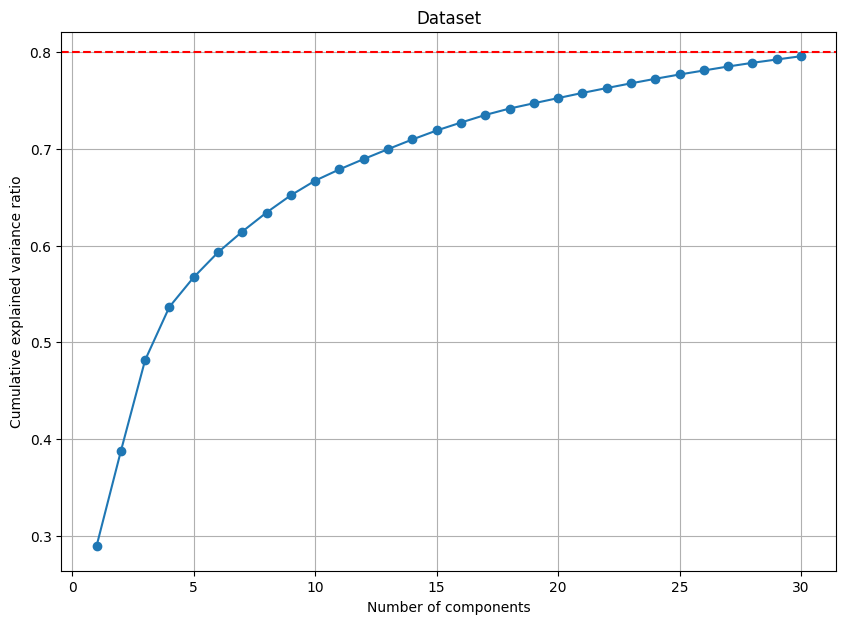

In [15]:
threshold = 0.8 # Threshold of explained variance

n_components = np.arange(1, k+1)

plt.figure(figsize=(10, 7))
plt.plot(n_components, cumulative_explained_variance, marker='o')
plt.axhline(threshold, color='r', linestyle='--')
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Dataset')
plt.show()

*The core of PCA is the choice of the number of components k, which is investigated by cumulative explained variance ratio and evaluate it we can preserve the information of original data. The variance ratio is obtained by the singular values vector S as shown in the equation below:$$\frac{\displaystyle \sum_{i=1}^{k}S_{i}}{\displaystyle \sum_{i=1}^{n}S_{i}}$$Where k is the number of components (k-dimensions) and n is the number of features. The choice of k is done by selection of the smallest values of k, which has a variance ratio higher than a specific threshold.*

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [16]:
images.shape

(35887, 48, 48)

In [17]:
reshaped_images.shape

(35887, 2304)

In [18]:
y = df["emotion"]
# X = data.drop(["emotion"], axis=1)
X = df['pixels'].apply(lambda x: np.fromstring(x, sep=' ')).tolist()

# Convert the list of lists to a numpy array
X = np.array(X)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [21]:
X_train.shape

(28709, 2304)

In [22]:
y_train.shape

(28709,)

### Random forest model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Define reduced parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [10, 20],
    'max_depth': [10, 20]
}

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Function to perform GridSearchCV and return the best estimator
def perform_grid_search(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Assuming X and y are defined and you want to split them into train and test sets
# Example:
# X, y = load_some_data_function()  # Replace with your data loading function


# Perform hyperparameter tuning and print results for RandomForestClassifier
print("Performing grid search for RandomForestClassifier")
best_estimator_rf, best_params_rf, best_score_rf = perform_grid_search(rf_classifier, param_grid_rf, X_train, y_train)
print(f"Best parameters for RandomForestClassifier: {best_params_rf}")
print(f"Best cross-validation score for RandomForestClassifier: {best_score_rf}")

# Train the best estimator on the full training set
best_estimator_rf.fit(X_train, y_train)

# Test the best estimator on the test set
y_pred_rf = best_estimator_rf.predict(X_test)
test_score_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test set accuracy for RandomForestClassifier: {test_score_rf}\n")


Performing grid search for RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 20}
Best cross-validation score for RandomForestClassifier: 0.3752482350664763
Test set accuracy for RandomForestClassifier: 0.41237113402061853



### DecisionTreeClassifier

In [24]:
param_grid_dt = {
    'max_depth': [1, 5, 10],
    'min_samples_split': [1, 2, 3]
}
# Initialize DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()
# Perform hyperparameter tuning and print results for DecisionTreeClassifier
print("Performing grid search for DecisionTreeClassifier")
best_estimator_dt, best_params_dt, best_score_dt = perform_grid_search(dt_classifier, param_grid_dt, X_train, y_train)
print(f"Best parameters for DecisionTreeClassifier: {best_params_dt}")
print(f"Best cross-validation score for DecisionTreeClassifier: {best_score_dt}")

# Train the best estimator on the full training set
best_estimator_dt.fit(X_train, y_train)

# Test the best estimator on the test set
y_pred_dt = best_estimator_dt.predict(X_test)
test_score_dt = accuracy_score(y_test, y_pred_dt)
print(f"Test set accuracy for DecisionTreeClassifier: {test_score_dt}\n")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Performing grid search for DecisionTreeClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_

Best parameters for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_split': 2}
Best cross-validation score for DecisionTreeClassifier: 0.3000103299332638
Test set accuracy for DecisionTreeClassifier: 0.3070493173585957

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.12      0.16       985
           1       0.00      0.00      0.00       102
           2       0.23      0.16      0.19      1043
           3       0.37      0.53      0.44      1765
           4       0.23      0.29      0.26      1210
           5       0.52      0.31      0.38       795
           6       0.28      0.29      0.29      1278

    accuracy                           0.31      7178
   macro avg       0.26      0.24      0.24      7178
weighted avg       0.30      0.31      0.29      7178



### MLP

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define reduced parameter grid for MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(20,), (30,)],  # reduced parameter grid for faster execution
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [50, 100]
}

# Initialize MLPClassifier
mlp_classifier = MLPClassifier()

# Function to perform GridSearchCV and return the best estimator
def perform_grid_search(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


# Perform hyperparameter tuning and print results for MLPClassifier
print("Performing grid search for MLPClassifier")
best_estimator_mlp, best_params_mlp, best_score_mlp = perform_grid_search(mlp_classifier, param_grid_mlp, X_train, y_train)
print(f"Best parameters for MLPClassifier: {best_params_mlp}")
print(f"Best cross-validation score for MLPClassifier: {best_score_mlp}")

# Train the best estimator on the full training set
best_estimator_mlp.fit(X_train, y_train)

# Test the best estimator on the test set
y_pred_mlp = best_estimator_mlp.predict(X_test)
test_score_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Test set accuracy for MLPClassifier: {test_score_mlp}\n")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))

Performing grid search for MLPClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLPClassifier: {'activation': 'relu', 'hidden_layer_sizes': (30,), 'max_iter': 50, 'solver': 'adam'}
Best cross-validation score for MLPClassifier: 0.3586678598625287
Test set accuracy for MLPClassifier: 0.37921426581220397

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.28      0.28       985
           1       0.39      0.29      0.34       102
           2       0.27      0.22      0.24      1043
           3       0.52      0.55      0.53      1765
           4       0.27      0.26      0.26      1210
           5       0.51      0.54      0.53       795
           6       0.34      0.37      0.35      1278

    accuracy                           0.38      7178
   macro avg       0.37      0.36      0.36      7178
weighted avg       0.37      0.38      0.38      7178



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define a smaller parameter grid for KNeighborsClassifier to reduce running time
param_grid_knn = {
    'n_neighbors': [1, 3],  # reduced parameter grid
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}

# Initialize KNeighborsClassifier
knn_classifier = KNeighborsClassifier()

# Function to perform GridSearchCV and return the best estimator
def perform_grid_search(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Assuming X and y are defined and you want to split them into train and test sets
# Example:
# X, y = load_some_data_function()  # Replace with your data loading function
# Optionally, use a subset of the data to further reduce running time (uncomment if needed)
# X_train, y_train = X_train[:500], y_train[:500]
# X_test, y_test = X_test[:100], y_test[:100]

# Perform hyperparameter tuning and print results for KNeighborsClassifier
print("Performing grid search for KNeighborsClassifier")
best_estimator_knn, best_params_knn, best_score_knn = perform_grid_search(knn_classifier, param_grid_knn, X_train, y_train)
print(f"Best parameters for KNeighborsClassifier: {best_params_knn}")
print(f"Best cross-validation score for KNeighborsClassifier: {best_score_knn}")

# Train the best estimator on the full training set
best_estimator_knn.fit(X_train, y_train)

# Test the best estimator on the test set
y_pred_knn = best_estimator_knn.predict(X_test)
test_score_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test set accuracy for KNeighborsClassifier: {test_score_knn}\n")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Performing grid search for KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score for KNeighborsClassifier: 0.3329269595339849
Test set accuracy for KNeighborsClassifier: 0.3952354416271942

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.31      0.34       985
           1       0.32      0.54      0.40       102
           2       0.41      0.38      0.39      1043
           3       0.45      0.44      0.44      1765
           4       0.33      0.30      0.31      1210
           5       0.54      0.54      0.54       795
           6       0.31      0.41      0.36      1278

    accuracy                           0.40      7178
   macro avg       0.39      0.42      0.40      7178
weighted avg       0.40      0.40      0.40      7178



## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [34]:
print("Randomforest")
print(classification_report(y_test, y_pred_rf))

Randomforest
              precision    recall  f1-score   support

           0       0.33      0.24      0.28       985
           1       1.00      0.25      0.39       102
           2       0.38      0.28      0.32      1043
           3       0.44      0.66      0.53      1765
           4       0.33      0.32      0.33      1210
           5       0.64      0.51      0.57       795
           6       0.37      0.35      0.36      1278

    accuracy                           0.41      7178
   macro avg       0.50      0.37      0.40      7178
weighted avg       0.42      0.41      0.40      7178



In [35]:
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.21      0.12      0.16       985
           1       0.00      0.00      0.00       102
           2       0.23      0.16      0.19      1043
           3       0.37      0.53      0.44      1765
           4       0.23      0.29      0.26      1210
           5       0.52      0.31      0.38       795
           6       0.28      0.29      0.29      1278

    accuracy                           0.31      7178
   macro avg       0.26      0.24      0.24      7178
weighted avg       0.30      0.31      0.29      7178



In [37]:
print("KNN:")
print(classification_report(y_test, y_pred_knn))

KNN:
              precision    recall  f1-score   support

           0       0.39      0.31      0.34       985
           1       0.32      0.54      0.40       102
           2       0.41      0.38      0.39      1043
           3       0.45      0.44      0.44      1765
           4       0.33      0.30      0.31      1210
           5       0.54      0.54      0.54       795
           6       0.31      0.41      0.36      1278

    accuracy                           0.40      7178
   macro avg       0.39      0.42      0.40      7178
weighted avg       0.40      0.40      0.40      7178



In [36]:
print("MLP:")
print(classification_report(y_test, y_pred_mlp))

MLP:
              precision    recall  f1-score   support

           0       0.29      0.28      0.28       985
           1       0.39      0.29      0.34       102
           2       0.27      0.22      0.24      1043
           3       0.52      0.55      0.53      1765
           4       0.27      0.26      0.26      1210
           5       0.51      0.54      0.53       795
           6       0.34      0.37      0.35      1278

    accuracy                           0.38      7178
   macro avg       0.37      0.36      0.36      7178
weighted avg       0.37      0.38      0.38      7178



Comparison of Models:
Accuracy:

RandomForest: 0.41
Decision Tree: 0.31
KNN: 0.40
MLP: 0.38
Precision (Weighted Average):

RandomForest: 0.42
Decision Tree: 0.30
KNN: 0.40
MLP: 0.37
Recall (Weighted Average):

RandomForest: 0.41
Decision Tree: 0.31
KNN: 0.40
MLP: 0.38
F1-Score (Weighted Average):

RandomForest: 0.40
Decision Tree: 0.29
KNN: 0.40
MLP: 0.38
Best Performing Model:
Based on the evaluation metrics, RandomForest is the best-performing model. It has the highest accuracy (0.41) and the highest weighted average precision (0.42) and recall (0.41), leading to the highest F1-score (0.40) compared to the other models. The KNN model also performs comparably well but is slightly behind RandomForest in terms of overall performance metrics.

Emotion Categories Analysis:
Most Accurate Emotion Category:
For RandomForest, the emotion category with the highest precision is 1 (though the support is low, indicating fewer samples), and the highest recall is for 3 with a value of 0.66. This indicates that RandomForest is best at correctly identifying instances of category 3.

Most Errors:
For RandomForest, category 1 has a high precision but a very low recall (0.25), indicating that while the model is very confident when it predicts this category, it misses many instances that belong to this category.
Category 0 has the lowest recall (0.24), indicating it often fails to correctly identify this category.
Conclusion:
RandomForest performs the best overall across various metrics (accuracy, precision, recall, F1-score). The model is particularly good at predicting category 3 but struggles with categories 0 and 1. The KNN model is also a strong performer, particularly in balanced metrics. However, for precision and recall, the RandomForest model has a slight edge, making it the preferred choice among the evaluated models.